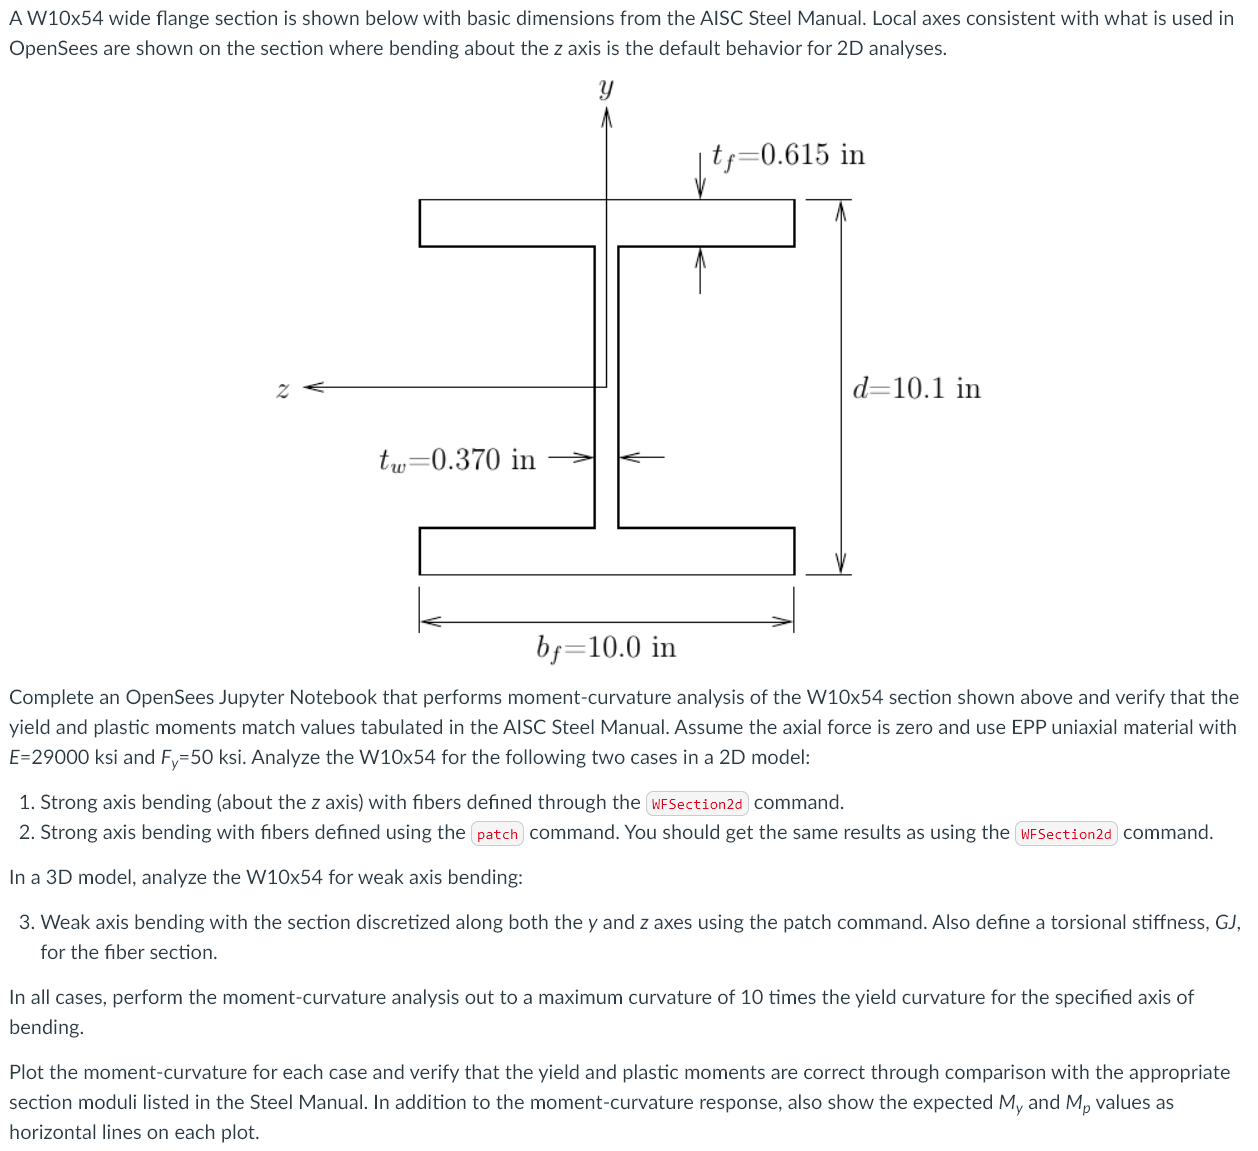

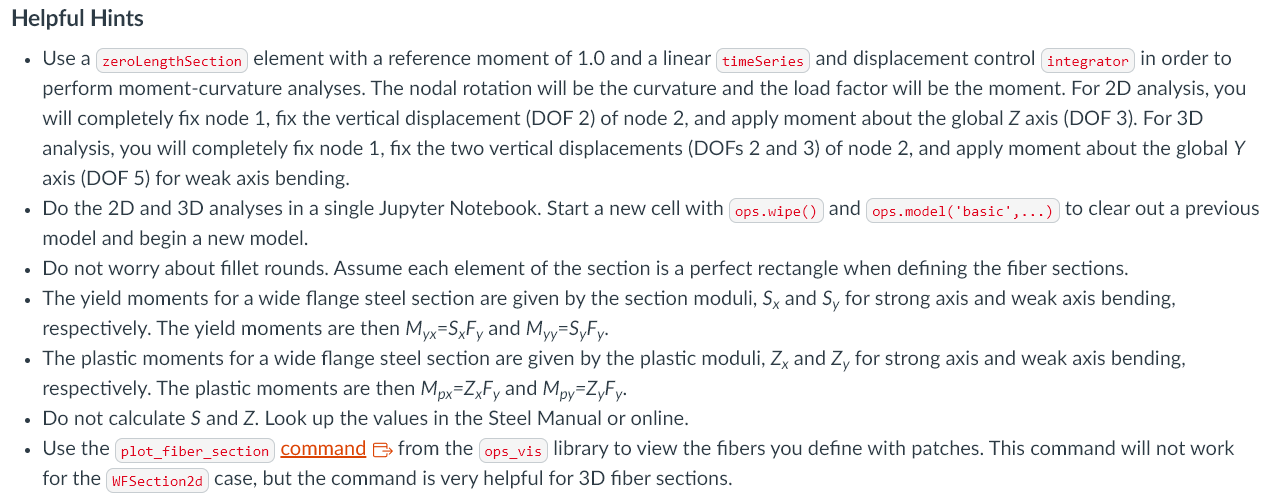

In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Units and conversions

In [2]:
inch = 1.0
kip = 1.0
ksi = kip/inch**2

## Material properties - A992 Steel

In [3]:
E = 29000*ksi
Fy = 50*ksi
nu = 0.3
G = 0.5*E/(1+nu)

## Sectional properties - W10x54

In [4]:
d = 10.1*inch
bf = 10*inch
tw = 0.37*inch
tf = 0.615*inch

J = 1.82*inch**4

# positive = compression
N = 0

## Steel Manual Values

In [5]:
# Section and plastic modulus
Sx = 59.6*inch**3
Zx = 66.2*inch**3
Sy = 20.5*inch**3
Zy = 31.1*inch**3

# Yield and plastic moment
Myx = Fy*Sx
Mpx = Fy*Zx
Myy = Fy*Sy
Mpy = Fy*Zy

print("strong axis")
print(Myx,Mpx)
print("weak axis")
print(Myy,Mpy)

strong axis
2980.0 3310.0
weak axis
1025.0 1555.0


## Analysis - WFSection2d - Strong

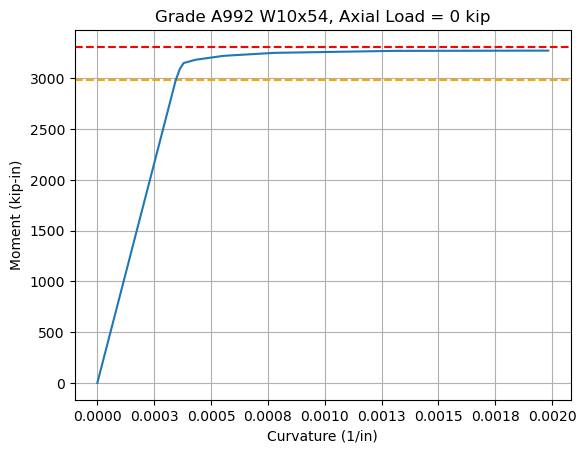

In [6]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0,0)
ops.node(2,0,0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

ops.uniaxialMaterial('Steel01',1,Fy,E,0)

ops.section('WFSection2d',1,1,d,tw,bf,tf,10,2)

ops.element('zeroLengthSection',1,1,2,1)

# to clear error messages
ops.system('UmfPack')
ops.algorithm('Linear')
ops.constraints('Plain')
ops.numberer('RCM')  

ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,-N,0,0)

ops.integrator('LoadControl',0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/E
epsMax = 0.01

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0,0,1)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,3,deps)

Mplot = np.zeros(1)
Kplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])

def precision(x, pos):
    return f'{x:.4f}'

plt.axhline(Myx, color='orange', linestyle='--')
plt.axhline(Mpx, color='red', linestyle='--')

plt.plot(Kplot, Mplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('Grade A992 W10x54, Axial Load = %d kip' % N)
plt.grid()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(precision))
plt.show()

## Analysis - Patch - Strong

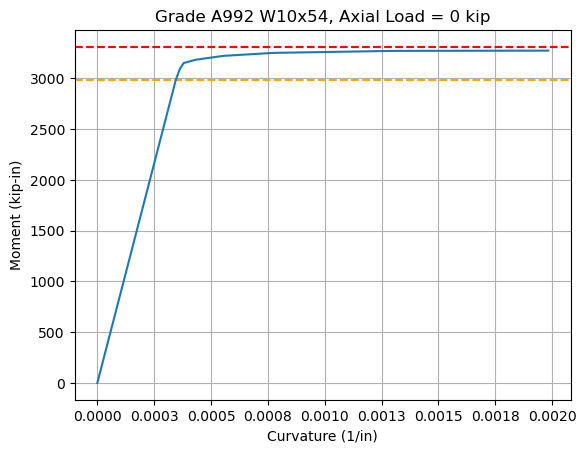

In [7]:
ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0,0)
ops.node(2,0,0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

ops.uniaxialMaterial('Steel01',1,Fy,E,0)

ops.section('Fiber',1)
ops.patch('rect',1,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf)
ops.patch('rect',1,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw)
ops.patch('rect',1,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf)

ops.element('zeroLengthSection',1,1,2,1)

# to clear error messages
ops.system('UmfPack')
ops.algorithm('Linear')
ops.constraints('Plain')
ops.numberer('RCM')  

ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,-N,0,0)

ops.integrator('LoadControl',0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/E
epsMax = 0.01

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0,0,1)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,3,deps)

Mplot = np.zeros(1)
Kplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])

def precision(x, pos):
    return f'{x:.4f}'

plt.axhline(Myx, color='orange', linestyle='--')
plt.axhline(Mpx, color='red', linestyle='--')


plt.plot(Kplot, Mplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('Grade A992 W10x54, Axial Load = %d kip' % N)
plt.grid()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(precision))
plt.show()

## Analysis - 3D Patch - Weak

WARNING Linear::solveCurrentStep() -the LinearSOE failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0
OpenSees > analyze failed, returned: -3 error flag
DisplacementControl::newStep(void) - failed in solver
StaticAnalysis::analyze() - the Integrator failed at step: 0 with domain at load factor 0
OpenSees > analyze failed, returned: -2 error flag


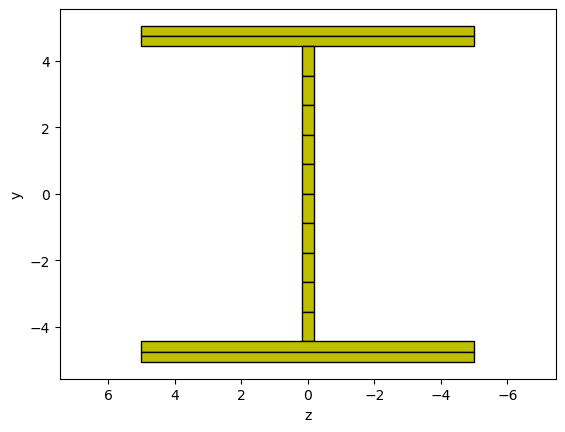

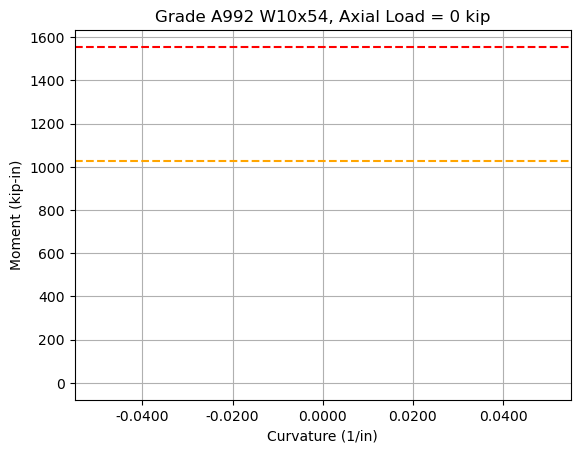

In [10]:
ops.wipe()
ops.model('basic','-ndm',3,'-ndf',6)

ops.node(1,0,0,0)
ops.node(2,0,0,0)

ops.fix(1,1,1,1,1,1,1)
ops.fix(2,0,1,1,0,0,0)

ops.uniaxialMaterial('Steel01',1,Fy,E,0)

ops.section('Fiber',1,'-GJ',G*J)
ops.patch('rect',1,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf)
ops.patch('rect',1,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw)
ops.patch('rect',1,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf)

ops.element('zeroLengthSection',1,1,2,1)

ops.system('UmfPack')
ops.algorithm('Linear')
ops.constraints('Plain')
ops.numberer('Plain')  

ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,-N,0,0,0,0,0)

ops.integrator('LoadControl',0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/E
epsMax = 0.01

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0,0,0,0,1,0)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,5,deps)

Mplot = np.zeros(1)
Kplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])

def precision(x, pos):
    return f'{x:.4f}'

fib_sec_1 = [['section','Fiber',1,'-GJ',G*J],
             ['patch','rect',1,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf],
             ['patch','rect',1,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw],
             ['patch','rect',1,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf]
             ]

opsv.plot_fiber_section(fib_sec_1)
plt.axis('equal')
plt.show()

plt.axhline(Myy, color='orange', linestyle='--')
plt.axhline(Mpy, color='red', linestyle='--')
plt.plot(Kplot, Mplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('Grade A992 W10x54, Axial Load = %d kip' % N)
plt.grid()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(precision))
plt.show()

# I couldn't get the 3D to work correctly.

# References

#### opsvis documentation plot steel and reinforced concrete fiber sections, https://opsvis.readthedocs.io/en/latest/ex_plot_fiber_section.html

#### How to properly use FuncFormatter(func), https://stackoverflow.com/questions/40511476/how-to-properly-use-funcformatterfunc

#### Matplotlib documentation, https://matplotlib.org/stable/index.html